# Mineral Area Analysis Notebook

## Read data, filter by geological units

Original center_points CRS: PROJCS["MRO_Mars_Equirectangular_IAU_2000_-45_00N_-52_50E",GEOGCS["GCS_Mars_2000_IAU_IAG_custom_sphere_lat45",DATUM["D_Mars_2000_IAU_IAG_custom_sphere_lat45",SPHEROID["Mars_2000_IAU_IAG_custom_sphere_lat45",3386150.74700337,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",-45],PARAMETER["central_meridian",-52.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Original geological_units CRS: GEOGCS["Mars (2015) - Sphere / Ocentric",DATUM["Mars (2015) - Sphere",SPHEROID["Mars (2015) - Sphere",3396190,0,AUTHORITY["IAU","49900"]],AUTHORITY["IAU","49900"]],PRIMEM["Reference Meridian",0,AUTHORITY["IAU","49900"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["IAU","49900"]]
Converting center points to geographic coordinat

/var/folders/fz/2g6_hdjd4yndg54gmwq1402c0000gn/T/ipykernel_32168/3545757216.py:296: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')


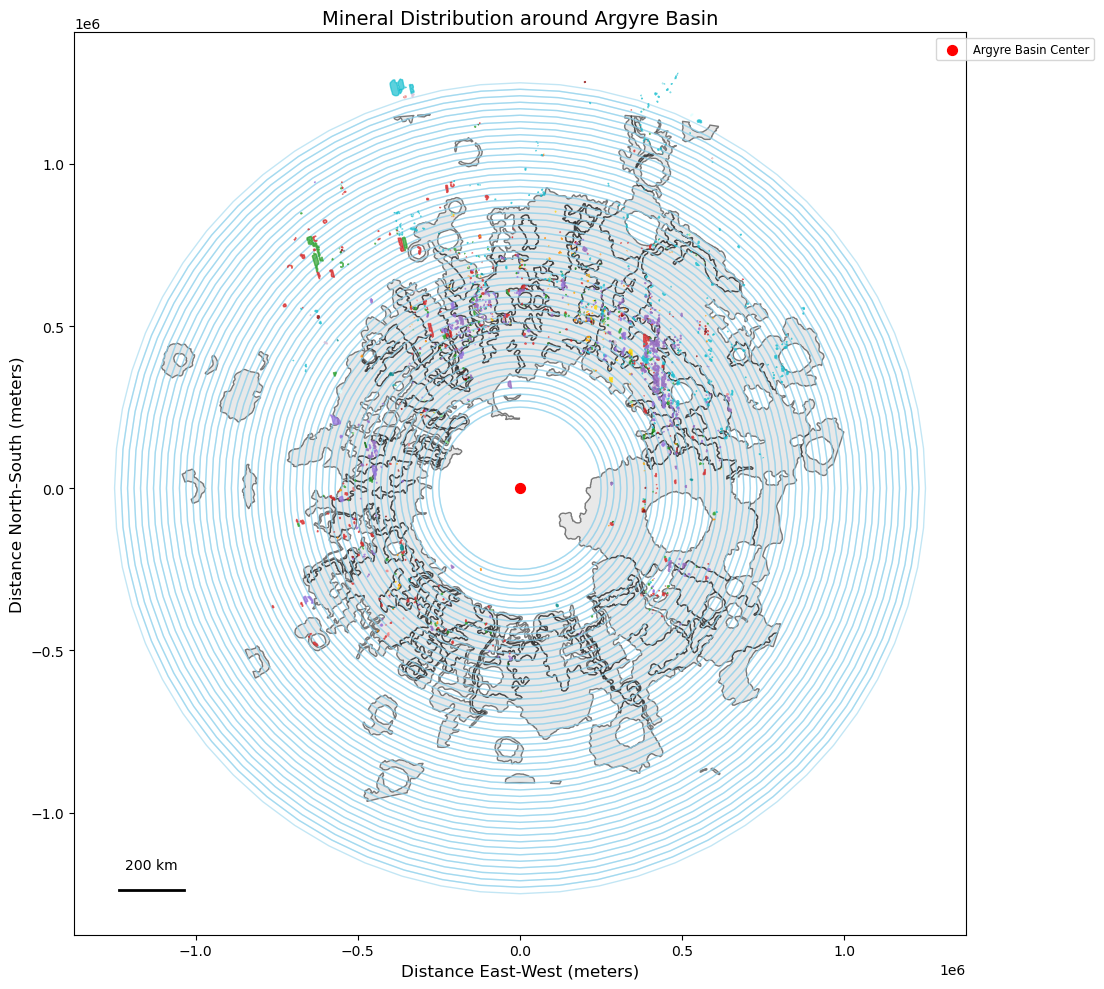

Analysis complete. Results saved to CSV files.


In [30]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from pyproj import CRS

# Define category colors
category_colors = {
    'type 1 olivine': {'High': 'tab:green', 'Moderate': 'darkgreen', 'Low': 'lightgreen'},
    'type 2 olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'olivine': {'High': 'tab:red', 'Moderate': 'darkred', 'Low': 'lightcoral'},
    'hcp + olivine': {'High': 'tab:purple', 'Moderate': 'mediumpurple', 'Low': 'thistle'},
    'lcp': {'High': 'tab:cyan', 'Moderate': 'darkcyan', 'Low': 'lightcyan'},
    'plagioclase': {'High': 'gold', 'Moderate': 'orange', 'Low': 'darkorange'},
}

# Set environment variable to work with non-Earth celestial bodies
os.environ["PROJ_IGNORE_CELESTIAL_BODY"] = "YES"

# Function to filter data based on confidence levels and categories
def filter_data(df, confidence_levels, categories_to_include):
    if not confidence_levels:
        return df[(df['Category'] != 'No valid mineral') & (df['Category'].isin(categories_to_include))]
    else:
        confidence_levels_lower = [a.lower() for a in confidence_levels]
        return df[(df['Category'] != 'No valid mineral') & 
                  (df['Confidence'].isin(confidence_levels_lower)) & 
                  (df['Category'].isin(categories_to_include))]

# File paths
geological_units_path = '../data/dohm_2015_map_units/argyre_geo_units_dohm2015.gpkg'
mineral_units_path = '../data/crism_mapping_results'
center_point_path = '../data/dohm_2015_map_units/arygre_center_point.shp'

# Load the geological units and center point(s)
geological_units = gpd.read_file(geological_units_path)
center_points = gpd.read_file(center_point_path)

# Print CRS information for debugging
print("Original center_points CRS:", center_points.crs)
print("Original geological_units CRS:", geological_units.crs)

# Define Mars-specific coordinate systems
# Mars geographic coordinate system (lat/lon)
mars_geographic_crs = CRS.from_string('+proj=longlat +a=3396190 +b=3376200 +no_defs +type=crs')

# We need to check if the center points are already in a geographic CRS
# If they're in a projected CRS, we need to convert them to geographic first
# to get proper lat/lon values

# Create a temporary copy of center_points in geographic coordinates if needed
if not center_points.crs.is_geographic:
    print("Converting center points to geographic coordinates first")
    # If we don't know what the current CRS is, we can try using EPSG:3857 or 3395 (common Mars projections)
    # or we can use the existing CRS if it's defined
    if center_points.crs is None:
        print("Warning: center_points has no CRS defined. Assuming EPSG:3857")
        center_points_temp = center_points.copy()
        center_points_temp.crs = "EPSG:3857"
        center_points_geo = center_points_temp.to_crs(mars_geographic_crs)
    else:
        center_points_geo = center_points.to_crs(mars_geographic_crs)
else:
    center_points_geo = center_points.copy()

# Now get the geographic coordinates (these should be proper lat/lon values)
center_lon = center_points_geo.geometry.x.mean()
center_lat = center_points_geo.geometry.y.mean()
print(f"Center point geographic coordinates: lon={center_lon}, lat={center_lat}")

# Set standard parallels 10 degrees away from the center latitude
std_parallel1 = max(-90, center_lat - 10)  # Ensure we don't go below -90
std_parallel2 = min(90, center_lat + 10)   # Ensure we don't go above 90

# Define a Mars Equidistant Conic projection centered on the Argyre basin
# This is suitable for accurate distance measurements around a central point
mars_projected_crs = CRS.from_string(
    f'+proj=eqdc +lat_0={center_lat} +lon_0={center_lon} +lat_1={std_parallel1} +lat_2={std_parallel2} '
    '+a=3396190 +b=3376200 +units=m +no_defs +type=crs'
)

# Make sure all datasets have a defined CRS before converting
if center_points.crs is None:
    print("Warning: center_points has no CRS. Assuming EPSG:4326")
    center_points.crs = "EPSG:4326"
    
if geological_units.crs is None:
    print("Warning: geological_units has no CRS. Assuming EPSG:4326")
    geological_units.crs = "EPSG:4326"

# If datasets are in different CRS, first convert everything to a common geographic CRS
# For Mars, we'll use our mars_geographic_crs
try:
    # Try to convert directly if the source CRS is recognized
    center_points = center_points.to_crs(mars_geographic_crs)
    geological_units = geological_units.to_crs(mars_geographic_crs)
except Exception as e:
    # If direct conversion fails, try an intermediate step through EPSG:4326
    print(f"Warning: CRS conversion failed: {e}")
    print("Attempting two-step conversion through EPSG:4326")
    
    if center_points.crs != "EPSG:4326":
        center_points = center_points.to_crs("EPSG:4326")
    if geological_units.crs != "EPSG:4326":
        geological_units = geological_units.to_crs("EPSG:4326")
    
    # Then convert from EPSG:4326 to mars_geographic_crs
    center_points = center_points.to_crs(mars_geographic_crs)
    geological_units = geological_units.to_crs(mars_geographic_crs)

# Then project both to the Mars-specific projected CRS for accurate distance calculations
center_points = center_points.to_crs(mars_projected_crs)
geological_units = geological_units.to_crs(mars_projected_crs)

# Load all the gpkg files in mineral_units_path, then concat them into a single gdf
mineral_units = gpd.GeoDataFrame()
for file in os.listdir(mineral_units_path):
    if file.endswith('.gpkg'):
        gdf = gpd.read_file(os.path.join(mineral_units_path, file))
        
        # Handle case when CRS is undefined
        if gdf.crs is None:
            print(f"Warning: File {file} has no CRS. Assuming same as center_points")
            gdf.crs = center_points.crs
        
        # Try to convert safely
        try:
            # First to geographic
            gdf = gdf.to_crs(mars_geographic_crs)
            # Then to projected
            gdf = gdf.to_crs(mars_projected_crs)
        except Exception as e:
            print(f"Warning: CRS conversion failed for {file}: {e}")
            print("Attempting two-step conversion")
            # Try through an intermediate well-known CRS
            gdf = gdf.to_crs("EPSG:4326")  
            gdf = gdf.to_crs(mars_geographic_crs)
            gdf = gdf.to_crs(mars_projected_crs)
            
        mineral_units = pd.concat([mineral_units, gdf], ignore_index=True)

# Filter data based on confidence levels and categories to include
confidence_levels_to_include = ['High', 'Moderate', 'Low']
categories_to_include = ['Type 1 olivine', 'Type 2 olivine', 'plagioclase', 'lcp', 'hcp + olivine']
catconf_to_include = []
for cat in categories_to_include:
    for conf in confidence_levels_to_include:
        catconf_to_include.append(f'{cat} ({conf})')

mineral_units = mineral_units[mineral_units['Category'].isin(catconf_to_include)]

# Fix invalid geometries
invalid_geometries = mineral_units[~mineral_units.is_valid]
if invalid_geometries.shape[0] > 0:
    print(f"Fixing {invalid_geometries.shape[0]} invalid geometries")
    mineral_units['geometry'] = mineral_units['geometry'].buffer(0)

# Define the geological units of interest
target_units = [
    'Argyre basin member 2', 'Argyre basin member 3', 'Argyre rim materials',
    'Argyre rim and basin materials', 'Argye rim and basin materials',
    'Argyre basin and rim materials', 'Young crater materials', 'Old crater materials'
]

# Filter geological units to include only the specified units
filtered_geological_units = geological_units[geological_units['UnitName'].isin(target_units)]

# Define buffer distances for rings in meters
# These are now in proper meters in the projected CRS
min_d, max_d = (250000, 1250000)
bs = 20000  # bin spacing in meters
buffer_distances = [min_d + i * bs for i in range(1+int((max_d - min_d) / bs))]

# Print buffer distance information
print(f"Creating {len(buffer_distances)} buffer rings from {min_d}m to {max_d}m with {bs}m spacing")

# Initialize an empty list to store results
summary_list = []
# Initialize an empty GeoDataFrame for the ring buffers
ring_buffers = gpd.GeoDataFrame(columns=['geometry', 'ring_id', 'distance'], crs=mars_projected_crs)
intersecting_units_list = []

# Calculate area of geological units within each ring buffer
for i, dist in enumerate(buffer_distances):
    outer_buffer = center_points.geometry.buffer(dist)
    
    # Check for an inner buffer (to create a true ring)
    if i == 0:
        ring = outer_buffer
    else:
        inner_buffer = center_points.geometry.buffer(buffer_distances[i - 1])
        ring = outer_buffer.difference(inner_buffer.unary_union)  # Create ring by subtracting inner buffer
    
    # Convert the ring to a GeoDataFrame
    ring_gdf = gpd.GeoDataFrame(geometry=ring, crs=mars_projected_crs)
    ring_gdf['distance'] = dist  # Add distance label for reference
    ring_gdf['ring_id'] = i + 1  # Add ring ID
       
    # Append to the main GeoDataFrame
    ring_buffers = pd.concat([ring_buffers, ring_gdf], ignore_index=True)
    
    # Intersect geological units with the ring to get the area of each unit within this ring
    intersecting_units = filtered_geological_units[filtered_geological_units.intersects(ring_gdf.unary_union)]
    intersecting_units = intersecting_units.copy()
    intersecting_units['geometry'] = intersecting_units.geometry.intersection(ring_gdf.unary_union)  # Crop to the ring
    intersecting_units['area_within_ring'] = intersecting_units.area  # Area is now in square meters in the projected CRS
    intersecting_units['distance'] = dist

    intersecting_units_list.append(intersecting_units)
    
    # Summarize the area by geological unit within the ring
    area_summary = (
        intersecting_units.groupby('UnitName')['area_within_ring']
        .sum()
        .reindex(target_units, fill_value=0)
        .reset_index()
    )
    
    # Add distance and ring ID to the summary
    area_summary['ring_id'] = i + 1
    area_summary['distance'] = dist
    
    # Append to the summary list
    summary_list.append(area_summary)

# Initialize an empty list to store results
mineral_area_within_ring = []

# Iterate over each unique category in the mineral_units GeoDataFrame
for category in mineral_units['Category'].unique():
    # Filter the mineral_units to get the current category's geometries
    category_units = mineral_units[mineral_units['Category'] == category]

    # Iterate over each intersecting geological unit
    for intersecting_units in intersecting_units_list:
        for _, geo_unit in intersecting_units.iterrows():
            # Intersect the geological unit with the current mineral category geometries
            intersected = category_units[category_units.intersects(geo_unit.geometry)]
            # Calculate the intersection area if there's any overlap
            if intersected.empty:
                # Append results for this geological unit and mineral category
                mineral_area_within_ring.append({
                    'geo_unit_id': np.nan,  
                    'mineral_category': category,
                    'area_within_ring': 0,
                    'distance': geo_unit['distance'],
                })
            else:
                intersection = intersected.geometry.intersection(geo_unit.geometry)
                area_within_ring = intersection.area.sum()  # Sum the area of the intersections if there are multiple parts

                # Append results for this geological unit and mineral category
                mineral_area_within_ring.append({
                    'geo_unit_id': geo_unit['UnitName'],  
                    'mineral_category': category,
                    'area_within_ring': area_within_ring,
                    'distance': geo_unit['distance'],
                })

# Convert the results into a new GeoDataFrame
mineral_area_gdf = gpd.GeoDataFrame(mineral_area_within_ring)
# Concatenate all summaries into a single DataFrame
summary_df = pd.concat(summary_list, ignore_index=True)

# Calculate total area per ring for normalization
area_sum_by_ring = summary_df.groupby(['ring_id', 'distance'])['area_within_ring'].sum().reset_index()
total_area = area_sum_by_ring['area_within_ring'].sum()
area_sum_by_ring['normalized_area'] = area_sum_by_ring['area_within_ring'] / total_area

# Create a visualization of the results
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the geological units
filtered_geological_units.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Geological Units')

# Plot the rings (buffered zones) around the central points
ring_buffers.plot(ax=ax, color='none', edgecolor='skyblue', alpha=0.5, label='Distance Rings')

# Plot mineral units by category and confidence level
for i, c in enumerate(catconf_to_include):
    cat, conf = c.split('(')
    cat = cat.strip().lower()
    conf = conf.replace(')', '').strip()
    if cat in category_colors:
        color = category_colors[cat][conf]
        mineral_units[mineral_units['Category'] == c].plot(
            ax=ax, color=color, edgecolor=color, alpha=0.7, label=c
        )

# Plot the center points
center_points.plot(ax=ax, color='red', markersize=50, label='Argyre Basin Center')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')

# Add title and labels
plt.title('Mineral Distribution around Argyre Basin', fontsize=14)
plt.xlabel('Distance East-West (meters)', fontsize=12)
plt.ylabel('Distance North-South (meters)', fontsize=12)

# Add a scale bar (approximate, for visualization purposes)
scale_bar_length = 200000  # 200 km in meters
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
bar_x = x_min + (x_max - x_min) * 0.05
bar_y = y_min + (y_max - y_min) * 0.05
ax.plot([bar_x, bar_x + scale_bar_length], [bar_y, bar_y], 'k-', lw=2)
ax.text(bar_x + scale_bar_length / 2, bar_y + (y_max - y_min) * 0.02, '200 km', 
        ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

# # Save results to CSV files for further analysis
# summary_df.to_csv('geological_units_by_distance.csv', index=False)
# mineral_area_gdf.to_csv('mineral_areas_by_distance.csv', index=False)
# area_sum_by_ring.to_csv('area_summary_by_ring.csv', index=False)

print("Analysis complete. Results saved to CSV files.")

## Prepare data frame for analysis

In [31]:
geo_units_areas_by_ring = [g.area.sum() for g in intersecting_units_list]

# Convert the list into a DataFrame
df = pd.DataFrame(mineral_area_within_ring)

# Pivot the DataFrame
pivot_df = df.pivot_table(index='distance', columns='mineral_category', values='area_within_ring', aggfunc='sum')

# Reset index to get 'distance' as a column (optional)
pivot_df.reset_index(inplace=True)

# Step 1: Extract mineral names (before parentheses)
pivot_df.columns = pivot_df.columns.str.extract(r'([a-zA-Z0-9\s\+]+)')[0]

# Step 2: Group by mineral name and sum the values for each mineral
pivot_df_combined = pivot_df.groupby(pivot_df.columns, axis=1).sum()

# Step 3: Move the 'distance' column to the first position
pivot_df_combined = pivot_df_combined[['distance'] + [col for col in pivot_df_combined.columns if col != 'distance']]

# pivot_df_combined['ring_geounit_area'] = geo_units_areas_by_ring

# Display the result
pivot_df_combined


,distance,Type 1 olivine,Type 2 olivine,hcp + olivine,lcp,plagioclase
0,250000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,270000.0,1.323949e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,290000.0,4.634553e+06,0.000000e+00,2.714790e+07,0.000000e+00,0.000000e+00
3,310000.0,4.607710e+06,4.008141e+07,0.000000e+00,0.000000e+00,1.347904e+06
4,330000.0,6.104330e+06,0.000000e+00,7.977704e+06,0.000000e+00,0.000000e+00
5,350000.0,2.593319e+06,0.000000e+00,1.447651e+06,0.000000e+00,0.000000e+00
6,370000.0,6.155254e+06,1.294430e+07,1.654858e+07,0.000000e+00,5.060529e+05
7,390000.0,2.228579e+07,1.182526e+08,2.770788e+07,1.944928e+06,1.049908e+07
8,410000.0,1.480372e+07,5.319029e+07,5.408129e+06,5.525295e+06,2.006043e+06
9,430000.0,4.747106e+07,3.892310e+07,2.095065e+06,7.685142e+05,5.825597e+06


## Make bar charts

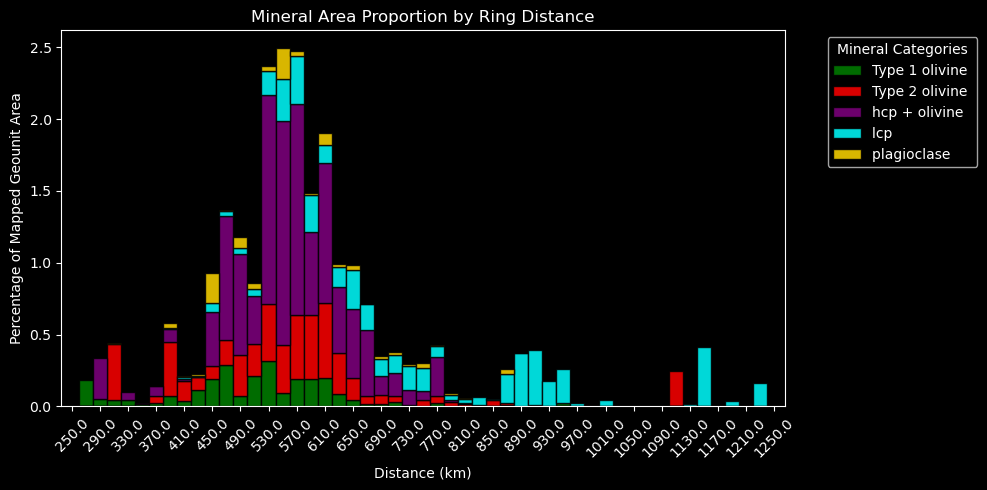

,Type 1 olivine,Type 2 olivine,hcp + olivine,lcp,plagioclase
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.181794,0.000000,0.000000,0.000000,0.000000
2,0.049310,0.000000,0.288843,0.000000,0.000000
3,0.044450,0.386661,0.000000,0.000000,0.013003
4,0.043536,0.000000,0.056897,0.000000,0.000000
5,0.013779,0.000000,0.007692,0.000000,0.000000
6,0.024312,0.051127,0.065363,0.000000,0.001999
7,0.071486,0.379317,0.088878,0.006239,0.033678
8,0.038836,0.139539,0.014188,0.014495,0.005263
9,0.111311,0.091267,0.004913,0.001802,0.013660


In [32]:
mineral_colors = [
    'green',  # Type 1 olivine
    'red',   # Type 2 olivine
    'purple',    # hcp + olivine
    'cyan',      # lcp
    'gold'    # plagioclase
]

# ----------------------------------------------------------------
# pick 1 of these:
# ----------------------------------------------------------------

# case 1:
# # Normalize the values to 100%
# pivot_df_combined_normalized = pivot_df_combined.drop('distance', axis=1).div(pivot_df_combined.drop('distance', axis=1).sum(axis=1), axis=0) * 100
# yl = "Relative Percentage of Mapped Geounit Area\nCovered by Each Mineral"
# ----------------------------------------------------------------

# # case 2:
# # normalize to ring with max area
# # Calculate the maximum area across all rows (row with highest total area)
# max_area = pivot_df_combined.drop('distance', axis=1).sum(axis=1).max()

# # Normalize each row by the maximum area value
# pivot_df_combined_normalized = pivot_df_combined.drop('distance', axis=1).div(max_area) * 100
# ----------------------------------------------------------------

# # case 3:
# normalize each column by the geounit area within that ring.
geo_units_areas_by_ring_series = pd.Series(geo_units_areas_by_ring)

# Divide each row by the corresponding value in geo_units_areas_by_ring and multiply by 100 for percentage
pivot_df_combined_normalized = pivot_df_combined.drop('distance', axis=1).div(geo_units_areas_by_ring_series, axis=0) * 100
yl = "Percentage of Mapped Geounit Area"
# ----------------------------------------------------------------

# Plot a stacked bar chart
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 5))
pivot_df_combined_normalized.plot(ax=ax, kind='bar', stacked=True, color=mineral_colors, width=1.0, edgecolor='black', alpha=0.85)

# Add labels and title
plt.title("Mineral Area Proportion by Ring Distance")
plt.xlabel("Distance (km)")
plt.ylabel(yl)
# plt.ylim([0, 100])
plt.xticks(range(0, len(pivot_df_combined), 2), round(pivot_df_combined['distance'][::2]/1000, 0), rotation=45)  # Adjust ticks and rotate them
plt.legend(title="Mineral Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

## save the plot as an svg
# plt.savefig('/Users/phillipsm/Documents/Research/Publications/2025_Argyre_feldspar/scratch_figs/mineral_area_proportions_by_ring_distance.svg', format='svg', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

pivot_df_combined_normalized

## Cumulative Distribution Plots

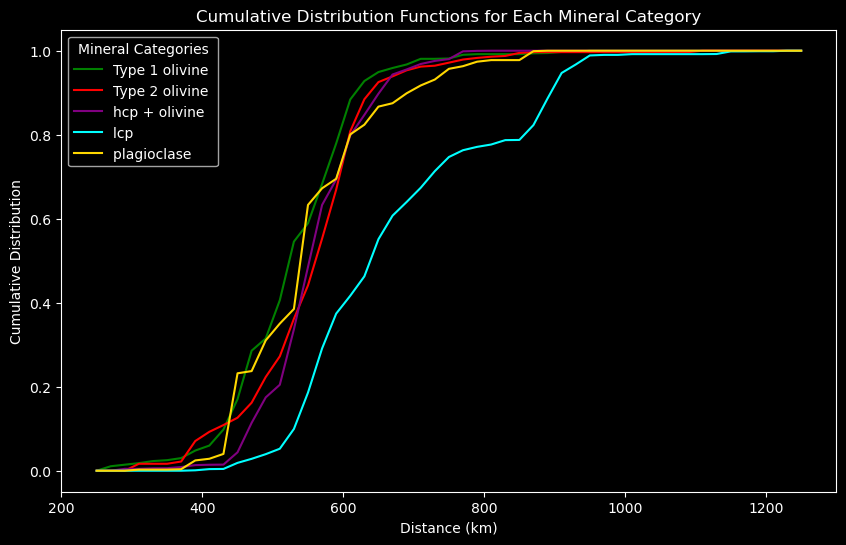

In [33]:
# Calculate the cumulative distribution functions (CDF) for each mineral category
cdf_df = pivot_df_combined.drop('distance', axis=1).cumsum()

# Normalize the CDFs to range from 0 to 1
cdf_df = cdf_df.div(cdf_df.iloc[-1])

# calculate the derivative of the cdf_df
# cdf_df = cdf_df.diff().fillna(cdf_df.iloc[0])

# Plot the CDFs
fig, ax = plt.subplots(figsize=(10, 6))

for i, column in enumerate(cdf_df.columns):
    ax.plot(pivot_df_combined['distance'] / 1000, cdf_df[column], label=column, color=mineral_colors[i])

# Add labels and title
ax.set_title('Cumulative Distribution Functions for Each Mineral Category')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Cumulative Distribution')
ax.legend(title='Mineral Categories')

# Show the plot
plt.show()

## Mineral proportions pie chart

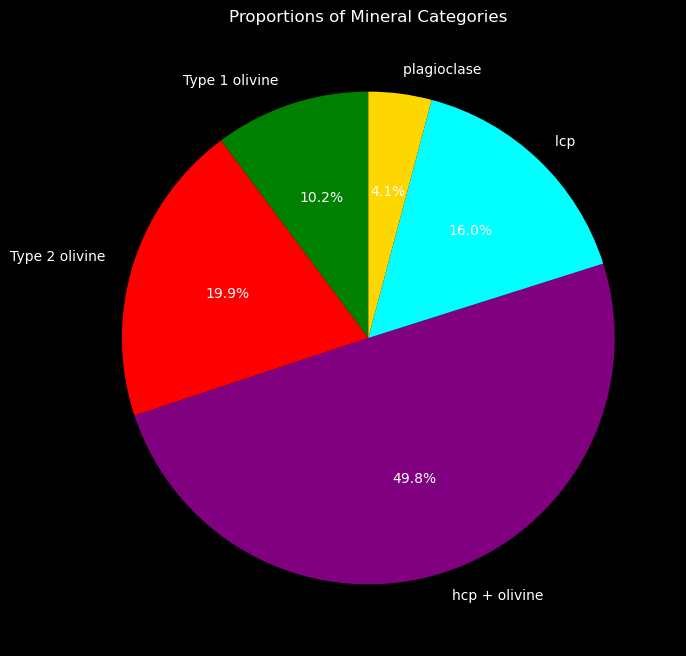

In [34]:
proportions = 100 * (pivot_df_combined.iloc[:,1:].sum() / pivot_df_combined.iloc[:,1:].sum().sum())
proportions
# Create a pie chart for the proportions
fig, ax = plt.subplots(figsize=(8, 8))
proportions.plot.pie(
    ax=ax, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['green', 'red', 'purple', 'cyan', 'gold'], 
    labels=proportions.index
)
ax.set_ylabel('')
ax.set_title('Proportions of Mineral Categories')
plt.show()

## Plagioclase box and whisker by ring distance

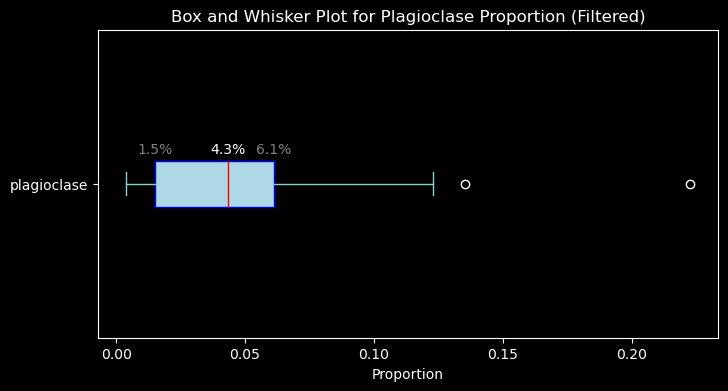

IQR for plagioclase proportion: 4.63%
MAD for plagioclase proportion: 2.74%


In [38]:
pivot_df_combined.columns = pivot_df_combined.columns.str.strip()

pivot_df_combined_proportional = pivot_df_combined.div(pivot_df_combined.sum(axis=1), axis=0)
pivot_df_combined_proportional
median_plagioclase = pivot_df_combined_proportional[pivot_df_combined_proportional['plagioclase'] > 0]['plagioclase'].median()
median_plagioclase*100

# Exclude rows where plagioclase is zero
filtered_data = pivot_df_combined_proportional[pivot_df_combined_proportional['plagioclase'] > 0]

# Create a box and whisker plot for the plagioclase proportion stats
fig, ax = plt.subplots(figsize=(8, 4))
filtered_data['plagioclase'].plot(kind='box', ax=ax, vert=False, patch_artist=True, 
                                  boxprops=dict(facecolor='lightblue', color='blue'),
                                  medianprops=dict(color='red'))

# Calculate the quartiles
q1 = filtered_data['plagioclase'].quantile(0.25)
median = filtered_data['plagioclase'].median()
q3 = filtered_data['plagioclase'].quantile(0.75)

# Add the quartile values as text on the plot
ax.text(q1, 1.1, f'{q1*100:.1f}%', color='gray', ha='center', fontsize=10)
ax.text(median, 1.1, f'{median*100:.1f}%', color='white', ha='center', fontsize=10)
ax.text(q3, 1.1, f'{q3*100:.1f}%', color='gray', ha='center', fontsize=10)

# Add labels and title
ax.set_title('Box and Whisker Plot for Plagioclase Proportion (Filtered)')
ax.set_xlabel('Proportion')

plt.show()

# Calculate the interquartile range (IQR) for the plagioclase proportion
q1 = filtered_data['plagioclase'].quantile(0.25) * 100
q3 = filtered_data['plagioclase'].quantile(0.75) * 100
iqr = q3 - q1
print(f"IQR for plagioclase proportion: {iqr:.2f}%")

# Calculate the Median Absolute Deviation (MAD) for the plagioclase proportion
mad = 100 * (filtered_data['plagioclase'] - filtered_data['plagioclase'].median()).abs().median()
print(f"MAD for plagioclase proportion: {mad:.2f}%")